# O que tem aqui

Notebook de entrega, iremos usar ChatGPT para formatar código e escrever explicações. Vamos fazer ele traduzir para ingles.

# Imports

In [237]:
import functools
import heapq
import itertools
import math
import os
import re
import subprocess
from collections import Counter, defaultdict
from dataclasses import dataclass
from pathlib import Path
from typing import (Any, Callable, Dict, Iterable, List, Optional, Set, Tuple,
                    Union)

import more_itertools
import toolz
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
# use retina resolution for matplotlib
%config InlineBackend.figure_format = 'retina'

# Data preprocessing

## Download dos dados

Para fazer download dos dados, vá até a pasta raiz e digite:
```bash
make get_raw_data

```
Para gerar esse Makefile, forneci a seguinte query ao chat GPT:
```
write a makefile to do the following:
- download file from http://ir.dcs.gla.ac.uk/resources/test_collections/cisi/cisi.tar.gz
- unzip it to the folder data/raw
- it should be on step "get_raw_data"
- operation should not be repeated if files already exist
- write help for the steps
```


# Conversão dos dados para um formato mais fácil de trabalhar

In [16]:
RAW_DATA_BASEDIR = Path('../data/raw')
!ls -lht {RAW_DATA_BASEDIR}

raw_files_path = {
    'query': RAW_DATA_BASEDIR / 'CISI.QRY',
    'all': RAW_DATA_BASEDIR / 'CISI.ALL',
    'rel': RAW_DATA_BASEDIR / 'CISI.REL',
}


total 6200
-rw-r--r--  1 marcospiau  staff   757K Feb 22 19:27 cisi.tar.gz
-rw-r--r--  1 marcospiau  staff    79K Feb 28  1994 CISI.REL
-rw-r--r--  1 marcospiau  staff    67K Feb 28  1994 CISI.QRY
-rw-r--r--  1 marcospiau  staff   4.5K Feb 28  1994 CISI.BLN
-rw-r--r--  1 marcospiau  staff   2.1M Feb 28  1994 CISI.ALL


Arquivos QRY e ALL são mais complicados e precisam de processamento. Tentei deixar processamento semelhante pra conseguir fazer os dois casos com uma mesma funcao.

Usei bastante o chatgpt, principalmente para escrever docstrings e typehints. Uma coisa curiosa é que constantemente ele removia a dataclass e utilizava classes padrão, de forma que precisei constamente instruir ele a a manter as dataclasses.

A biblioteca [toolz](https://toolz.readthedocs.io/en/latest/) foi utilizada para deixar o código modular e funcional.

In [17]:
# (.I) ID
# (.T) Title
# (.W) Abstract
# (.B) Publication date of the article
# (.A) Author list
# (.N) Information when entry was added
# (.X) List of cross-references to other documents

renames_docs_all = {
    '.I': 'id',
    '.T': 'title',
    '.W': 'abstract',
    '.B': 'publication_date',
    '.A': 'author_list',
    '.N': 'added_date',
    '.X': 'cross_references'
}

process_doc_all = toolz.compose_left(
    # for each tag, get renamed tag, and join texts for tag
    functools.partial(more_itertools.map_reduce,
                      keyfunc=lambda x: renames_docs_all[x.tag],
                      valuefunc=lambda x: x.text,
                      reducefunc=lambda x: ' '.join(x)),
    # keeps only desired keys
    toolz.curried.keyfilter(lambda x: x in {'id', 'title', 'abstract'}),
    # convert id to int
    toolz.curried.update_in(keys=['id'], func=int)
)

# (.I) ID
# (.W) Query
# (.A) Author list
# (.N) Authors name and some keywords on what the query searches for

renames_docs_queries = {
    '.I': 'id',
    '.W': 'query',
    '.T': 'title',
    '.A': 'author_list',
    # '.N': 'other_query_infos',
    '.B': 'publication_date',
    # '.X': 'cross_references'
}

process_doc_qry = toolz.compose_left(
    functools.partial(more_itertools.map_reduce,
                      keyfunc=lambda x: renames_docs_queries[x.tag],
                      valuefunc=lambda x: x.text,
                      reducefunc=lambda x: ' '.join(x)),
    toolz.curried.keyfilter(lambda x: x in {'id', 'query'}),
    toolz.curried.update_in(keys=['id'], func=int)
)

Explicação do código acima em português:
```
Este código é usado para renomear e processar informações em documentos e consultas de um conjunto de dados. Ele define dois dicionários de renomeação, renames_docs_all e renames_docs_queries, que mapeiam as tags de um documento ou consulta para nomes mais descritivos. Por exemplo, a tag .I é mapeada para id, a tag .T é mapeada para title e assim por diante.

O código usa a biblioteca toolz para compor funções e processar os documentos e consultas. A função more_itertools.map_reduce é usada para mapear as tags para os nomes renomeados e juntar os textos de cada tag em uma única string. Em seguida, a função toolz.curried.keyfilter é usada para manter apenas as chaves desejadas nos dicionários resultantes, e a função toolz.curried.update_in é usada para converter a tag id em um número inteiro.

O primeiro bloco de código é usado para processar os documentos, e o segundo bloco é usado para processar as consultas. O bloco de processamento de documentos mantém apenas as chaves id, title e abstract, enquanto o bloco de processamento de consultas mantém apenas as chaves id e query. Em ambos os casos, a tag id é convertida em um número inteiro usando a função int().
```

Explicação em inglês:
```
This code is used to rename and process information in documents and queries from a dataset. It defines two renaming dictionaries, renames_docs_all and renames_docs_queries, that map the tags of a document or query to more descriptive names. For example, the tag .I is mapped to id, the tag .T is mapped to title, and so on.

The code uses the toolz library to compose functions and process the documents and queries. The more_itertools.map_reduce function is used to map the tags to the renamed names and join the texts of each tag into a single string. Then, the toolz.curried.keyfilter function is used to keep only the desired keys in the resulting dictionaries, and the toolz.curried.update_in function is used to convert the id tag to an integer.

The first block of code is used to process the documents and keeps only the id, title, and abstract keys, while the second block of code is used to process the queries and keeps only the id and query keys. In both cases, the id tag is converted to an integer using the int() function.

```

In [18]:
"""
This module defines functions to parse CISI all or query files, which contain bibliographic information for documents. The parsed information is returned in a dictionary format.

The parse_cisi_all_or_qry function takes three arguments: path which is the path to the file to parse, process_doc_fn which is a function that takes a list of IdTagText objects or an iterable of IdTagText objects and returns a dictionary, and return_dict which is a boolean indicating whether to return a dictionary or a list of dictionaries.

The function returns a dictionary if return_dict is True, where the keys are document IDs and the values are the processed documents. Otherwise, it returns a list of processed documents.

If the process_doc_fn function returns a dictionary, it must contain an 'id' key with a string value representing the document ID.

The function raises an AssertionError if the document IDs are not unique.

The IdTagText class represents a single tag and its corresponding text, with an additional id attribute.

The process_cisi_all and process_cisi_qry functions are partial functions of parse_cisi_all_or_qry that set process_doc_fn to process_doc_all and process_doc_qry, respectively.
"""
@dataclass
class IdTagText:
    id: str
    tag: str
    text: str


def parse_cisi_all_or_qry(
    path: str,
    process_doc_fn: Callable[[Iterable[IdTagText]], Dict[str, Any]],
    return_dict: bool = False,
) -> Union[List[Dict[str, Any]], Dict[str, Any]]:
    """Parses a CISI all or query file.

    Args:
        path: A string representing the path to the file to parse.
        process_doc_fn: A function that receives a list of IdTagText or an iterable of
          IdTagText as input, and returns a dictionary.
        return_dict: A boolean indicating whether to return a dictionary or a list of
          dictionaries.

    Returns:
        If return_dict is True, a dictionary with the document IDs as keys and
        processed documents as values. Otherwise, a list of processed documents.

    Raises:
        AssertionError: If the document IDs are not unique.
    """
    markers = [r'^\.I\s(\d+)$', '\.T$', '\.A$', '\.B$', '\.W$', '\.X$', '\.N$']
    marker_pattern = re.compile('|'.join(markers))

    def gen_items() -> Iterable[IdTagText]:
        with open(path, 'r') as f:
            for line in map(str.strip, f):
                match = marker_pattern.match(line)
                # match occurs for lines with tags
                if match:
                    # if match.group(1) is not None, it means that the tag is .I
                    # and the group contains the ID
                    if match.group(1):
                        id_ = match.group(1)
                        yield IdTagText(id_, '.I', id_)
                    else:
                        tag = match.group(0).strip()
                else:
                    # if match is None, it means that the line is a text
                    # just propagate tag and id
                    yield IdTagText(id_, tag, line)

    out = [
        process_doc_fn(group)
        for _, group in itertools.groupby(gen_items(), key=lambda x: x.id)
    ]
    assert len(out) == len({x['id'] for x in out}), 'IDs are not unique'
    return {x['id']: x for x in out} if return_dict else out


process_cisi_all = functools.partial(parse_cisi_all_or_qry,
                                     process_doc_fn=process_doc_all)
process_cisi_qry = functools.partial(parse_cisi_all_or_qry,
                                     process_doc_fn=process_doc_qry)

Alguns exemplos de dados processados:

In [19]:
corpus = process_cisi_all(raw_files_path['all'])
corpus[0]

{'id': 1,
 'title': '18 Editions of the Dewey Decimal Classifications',
 'abstract': "The present study is a history of the DEWEY Decimal Classification.  The first edition of the DDC was published in 1876, the eighteenth edition in 1971, and future editions will continue to appear as needed.  In spite of the DDC's long and healthy life, however, its full story has never been told.  There have been biographies of Dewey that briefly describe his system, but this is the first attempt to provide a detailed history of the work that more than any other has spurred the growth of librarianship in this country and abroad."}

In [20]:
queries = process_cisi_qry(raw_files_path['query'])
len(queries), queries[0]

(112,
 {'id': 1,
  'query': 'What problems and concerns are there in making up descriptive titles? What difficulties are involved in automatically retrieving articles from approximate titles? What is the usual relevance of the content of articles to their titles?'})

O arquivo qrels é mais simples e pode ser lido de forma mais simples. O resultado é um dicionário com a query como chave e uma lista de documentos relevantes para aquela query.

In [27]:
def load_qrels(path: str) -> Dict[int, Set[int]]:
    """
    Load relevance judgments from a file with qrels format.

    Args:
        path (str): Path to the qrels file.

    Returns:
        A dictionary where keys are query IDs (int) and values are sets of relevant
        document IDs (int).
    """
    out = defaultdict(set)
    with open(path, 'r') as f:
        for line in map(str.strip, f):
            qid, docid, _, _ = line.split()
            out[int(qid)].add(int(docid))
    out.default_factory = None

    return out

qrels = load_qrels(raw_files_path['rel'])
print('Examplo de 5 qrels:', list(itertools.islice(qrels.items(), 5)), sep='\n')

Examplo de 5 qrels:
[(1, {1281, 650, 1162, 524, 269, 1164, 783, 894, 150, 28, 541, 35, 291, 38, 680, 42, 43, 1195, 429, 813, 1196, 52, 820, 189, 192, 65, 193, 195, 320, 576, 582, 711, 76, 589, 465, 466, 722, 86, 215, 726, 603, 482, 483, 868, 869, 510}), (2, {669, 29, 670, 674, 429, 690, 692, 309, 695, 700, 319, 704, 68, 197, 324, 709, 720, 213, 214, 731, 733, 738, 740, 1136, 499, 636}), (3, {640, 131, 1027, 133, 901, 136, 138, 140, 909, 911, 1169, 532, 660, 664, 537, 1179, 412, 540, 1053, 1181, 803, 1190, 1191, 553, 554, 555, 1326, 60, 445, 454, 585, 461, 590, 463, 85, 469, 599, 346, 359, 363, 114, 372, 123, 126}), (4, {321, 420, 329, 332, 980, 310, 601, 315}), (5, {642, 648, 137, 1035, 525, 400, 528, 32, 692, 56, 187, 188, 191, 65, 451, 453, 1356, 339, 471, 1246, 241, 114, 370, 124})]


Abaixo nós filtramos queries que constam no arquivo de qrels, pois não conseguimos avaliar queries que não constam no arquivo de qrels. O número de queries vai de 112 para 76.

In [28]:
# Filtrando queries que aparecem no qrels:
queries = [x for x in queries if x['id'] in qrels.keys()]
len(queries), queries[0]

(76,
 {'id': 1,
  'query': 'What problems and concerns are there in making up descriptive titles? What difficulties are involved in automatically retrieving articles from approximate titles? What is the usual relevance of the content of articles to their titles?'})

Abaixo, vemos que todos os qrels possuem relevância igual a zero. Por isso, vamos interpretar que caso um documento esteja relacionado a uma query, ele é relevante para essa query.

In [29]:
import pandas as pd
df = pd.read_csv(raw_files_path['rel'], delim_whitespace=True, header=None, names=['qid', 'docid', 'nao', 'sei']).astype(str)
display(df.describe())
del df

,qid,docid,nao,sei
count,3114,3114,3114,3114
unique,76,1162,1,1
top,44,375,0,0.0
freq,155,15,3114,3114


# Implementação do BM25

Aqui o ChatGPT foi usado de forma iterativa até conseguir uma versão que fosse clara e que funcionasse. Tentei começar fazendo algo complicado logo de cara (ex: tentando vetorizar código com numpy), mas no final obtive resultados ruins e voltei para uma abordagem mais simples.

O chatGPT ajudou bastante na verificação de erros e na escrita de docstrings e typehints. Valores default de k1 e b foram escolhidos pelo ChatGPT.

Encontrei algumas implementações de BM25 em python (ex: http://ethen8181.github.io/machine-learning/search/bm25_intro.html), mas optei por ir fazendo aos poucos com ajuda do chatGPT para ir aprendendo. Espeficialmente, quebrei o cálculo de do IDF e do inverted index em funções separadas para facilitar o aprendizado.

Também optei por usar estruturas de dados da biblioteca padrão do python, como dicionários e listas, ao invés de bibliotecas como numpy e pandas. Isso foi feito para facilitar o aprendizado e a compreensão do código.

In [40]:
def tokenize(text: str) -> List[str]:
    """
    Tokenize the input text by removing all non-word and non-space characters and
    converting all characters to lowercase.

    Args:
        text (str): The input text to be tokenized.

    Returns:
        List[str]: A list of tokens obtained from the cleaned text.

    Example:
        >>> text = "The quick brown fox jumps over the lazy dog."
        >>> tokenize(text)
        ['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']
    """
    cleaned_text = re.sub(r'[^\w\s]', '', text).lower()
    return cleaned_text.split()

In [44]:
def build_inverted_index(ids_and_tokens: List[Tuple[int, List[str]]]) -> dict:
    """Build an inverted index from the given document IDs and tokens.

    Args:
        ids_and_tokens: A list of tuples where the first element is an integer
            representing the document ID and the second element is a list of
            strings representing the tokens in the document.

    Returns:
        A dictionary representing the inverted index, where the keys are tokens
        found in the documents, and the values are sets of document IDs that
        contain the token.

    Example:
        >>> ids_and_tokens = [(1, ['foo', 'bar']), (2, ['baz', 'qux', 'foo']),
                             (3, ['qux', 'quux'])]
        >>> build_inverted_index(ids_and_tokens)
        {'foo': {1, 2}, 'bar': {1}, 'baz': {2}, 'qux': {2, 3}, 'quux': {3}}

    Note:
        - The inverted index is a common data structure used in information
          retrieval to quickly find documents that contain a given query term.
        - This implementation uses a defaultdict to avoid having to explicitly
          check if a token is already in the dictionary before adding a document
          ID to its set of postings.
    """
    inverted_index = defaultdict(set)
    for doc_id, tokens in ids_and_tokens:
        for token in tokens:
            inverted_index[token].add(doc_id)
    inverted_index.default_factory = None
    return inverted_index


# inverted_index = build_inverted_index((x['id'] for x in corpus[:5]), (tokenize(x['abstract']) for x in corpus[:5]))
inverted_index = build_inverted_index(
    (x['id'], tokenize(x['abstract'])) for x in corpus[:2])
print('Exemplo de 5 tokens do inverted index:',
      list(itertools.islice(inverted_index.items(), 5)),
      sep='\n')


Exemplo de 5 tokens do inverted index:
[('the', {1, 2}), ('present', {1}), ('study', {1}), ('is', {1, 2}), ('a', {1, 2})]


In [58]:
def calculate_idf(inverted_index: Dict[str, Set[int]], corpus_size: int,
                  eps: float = 1e-8) -> Dict[str, float]:
    """Calculate inverse document frequency (IDF) for each token in a corpus.

    Args:
        inverted_index: A dictionary where keys are tokens and values are sets
            of document IDs that contain the token.
        corpus_size: An integer representing the total number of documents in the corpus.
        eps: A small value added to the denominator to avoid division by zero.

    Returns:
        A dictionary where keys are tokens and values are the corresponding IDF scores.

    Notes:
        - IDF is a measure of how important a token is to a corpus.
        - The formula used here to calculate IDF is:
            log((corpus_size - len(doc_ids) + 0.5) / (len(doc_ids) + 0.5) + eps)
          where doc_ids is the set of document IDs that contain the token.
        - The `eps` parameter is used to avoid division by zero when a token is present in
          all documents in the corpus.

    Examples:
        >>> inverted_index = {'foo': {1, 2}, 'bar': {1}, 'baz': {2, 3}, 'qux': {2, 3}}
        >>> corpus_size = 3
        >>> calculate_idf(inverted_index, corpus_size)
        {'foo': 0.28768207245178085,
         'bar': 0.6931471805599453,
         'baz': 0.28768207245178085,
         'qux': 0.28768207245178085}

    """
    idf = {}
    for token, doc_ids in inverted_index.items():
        idf[token] = math.log(
            (corpus_size - len(doc_ids) + 0.5) / (len(doc_ids) + 0.5) + eps)
    return idf

print('Exemplo de 5 tokens do inverted index:',
      list(itertools.islice(inverted_index.items(), 5)),
        sep='\n')

Exemplo de 5 tokens do inverted index:
[('the', {1, 2}), ('present', {1}), ('study', {1}), ('is', {1, 2}), ('a', {1, 2})]


Repare que o exemplo gerado pelo ChatGPT na docstring está incorreto, tentei forçar ele a escrever um exemplo correto, mas não consegui. O correto é:


In [61]:
calculate_idf({'foo': {1, 2}, 'bar': {1}, 'baz': {2, 3}, 'qux': {2, 3}}, 3)

{'foo': -0.5108256070993241,
 'bar': 0.5108256297659907,
 'baz': -0.5108256070993241,
 'qux': -0.5108256070993241}

In [126]:
# import numpy as np
# from tqdm.auto import tqdm
# import math
# from collections import Counter
# import heapq

# Gerado pelo chatgpt com o prompt 
# use single quotes, respect char length of 79
# ENGLISH_STOPWORDS_CHATGPT = {
ENGLISH_STOPWORDS_CHATGPT = {
'a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an',
'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been',
'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn',
"couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't",
'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from',
'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven',
"haven't", 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself',
'his', 'how', 'i', 'if', 'in', 'into', 'is', 'isn', "isn't", 'it', "it's",
'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more',
'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor',
'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our',
'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan',
"shan't", 'she', "she's", 'should', "should've", 'shouldn', "shouldn't",
'so', 'some', 'such', 't', 'than', 'that', "that'll", 'the', 'their',
'theirs', 'them', 'themselves', 'then', 'there', 'these', 'they', 'this',
'those', 'through', 'to', 'too', 'under', 'until', 'up', 've', 'very', 'was',
'wasn', "wasn't", 'we', 'were', 'weren', "weren't", 'what', 'when', 'where',
'which', 'while', 'who', 'whom', 'why', 'will', 'with', 'won', "won't",
'wouldn', "wouldn't", 'y', 'you', "you'd", "you'll", "you're", "you've",
'your', 'yours', 'yourself', 'yourselves'
}


class BM25:
    def __init__(self, corpus: List[dict], stopwords: Optional[Set[str]] = None, 
                 k1: float = 1.2, b: float = 0.75) -> None:
        """
        Initializes the BM25 retrieval model.

        Args:
            corpus: List of dictionaries containing 'id' and 'text' keys, 
                where 'id' is an integer and 'text' is the tokenized text.
            stopwords: Set of stop words to remove from the corpus (default: None).
            k1: Positive tuning parameter for adjusting the impact of term frequency 
                on document relevance score (default: 1.2).
            b: Positive tuning parameter for adjusting the impact of document length 
                on document relevance score (default: 0.75).
        """
        self.k1 = k1
        self.b = b

        # corpus is tokenized
        self.corpus = {doc['id']: tokenize(doc['text']) for doc in corpus}
        if stopwords is not None:
            self.corpus = {
                id_: [token for token in tokens if token not in stopwords]
                for id_, tokens in self.corpus.items()
            }
        self.inverted_index = build_inverted_index(self.corpus.items())
        self.idf = calculate_idf(self.inverted_index, len(corpus))
        self.doc_lengths = {
            id_: len(text)
            for id_, text in self.corpus.items()
        }
        self.avg_doc_length = sum(self.doc_lengths.values()) / len(
            self.doc_lengths)

    def score(self, query: str, doc_id: int) -> float:
        """
        Calculates the relevance score of a document for a given query.

        Args:
            query: Query text.
            doc_id: ID of the document in the corpus.

        Returns:
            Relevance score of the document for the query.
        """
        query_tokens = tokenize(query)
        doc_token_counts = Counter(self.corpus[doc_id])
        score = 0
        for token in query_tokens:
            if token not in self.idf:
                continue
            tf = doc_token_counts[token]
            score += self.idf[token] * tf * (self.k1 + 1) / (
                tf + self.k1 *
                (1 - self.b +
                 self.b * self.doc_lengths[doc_id] / self.avg_doc_length))
        return score

    def retrieve(self, query: str, k: int = 10) -> List[dict]:
        """
        Retrieves the top-k documents for a given query.

        Args:
            query: Query text.
            k: Number of documents to retrieve (default: 10).

        Returns:
            List of document dictionaries with 'id' and 'score' keys.
        """
        ids_and_scores = ((doc_id, self.score(query, doc_id))
                          for doc_id in self.corpus.keys())
        top_ids_and_scores = heapq.nlargest(k,
                                            ids_and_scores,
                                            key=lambda x: x[1])
        return [{
            'id': docid,
            'score': score
        } for  docid, score in top_ids_and_scores]

    def get_results_for_all_queries(self,
                                    queries: List[dict],
                                    k: int = 10) -> Dict[int, List[dict]]:
        """
        Retrieves the top-k documents for all queries.

        Args:
            queries: List of query dictionaries with 'id' and 'text' keys.
            k: Number of documents to retrieve (default: 10).

        Returns:
            Dictionary mapping query IDs to a list of document dictionaries with 'id' and 'score' keys.
        """
        return {
            query['id']: self.retrieve(query['query'], k)
            for query in tqdm(queries, desc='Retrieving')
        }

Exemplo de uso:

In [127]:
corpus_abstracts = [{'id': x['id'], 'text': x['abstract']} for x in corpus]
bm25 = BM25(corpus=corpus_abstracts, stopwords=ENGLISH_STOPWORDS_CHATGPT)
# bm25 = BM25(corpus=corpus_abstracts, k1=0.9, b = 0.4)

In [128]:
bm25.score(query=corpus[0]['abstract'], doc_id=1)

220.28031216326931

In [129]:
corpus[0]

{'id': 1,
 'title': '18 Editions of the Dewey Decimal Classifications',
 'abstract': "The present study is a history of the DEWEY Decimal Classification.  The first edition of the DDC was published in 1876, the eighteenth edition in 1971, and future editions will continue to appear as needed.  In spite of the DDC's long and healthy life, however, its full story has never been told.  There have been biographies of Dewey that briefly describe his system, but this is the first attempt to provide a detailed history of the work that more than any other has spurred the growth of librarianship in this country and abroad."}

In [130]:
bm25.retrieve(query=corpus[0]['abstract'], k=10)

[{'id': 1, 'score': 220.28031216326931},
 {'id': 1152, 'score': 33.76075590140294},
 {'id': 1393, 'score': 33.20818229839429},
 {'id': 361, 'score': 33.11173965878908},
 {'id': 20, 'score': 32.27518710308345},
 {'id': 260, 'score': 31.677965483165565},
 {'id': 354, 'score': 31.20879627936035},
 {'id': 1251, 'score': 27.262693384901},
 {'id': 749, 'score': 26.557344989257835},
 {'id': 414, 'score': 25.43222600692836}]

In [131]:
bm25.retrieve(query=corpus[0]['abstract'], k=10)

[{'id': 1, 'score': 220.28031216326931},
 {'id': 1152, 'score': 33.76075590140294},
 {'id': 1393, 'score': 33.20818229839429},
 {'id': 361, 'score': 33.11173965878908},
 {'id': 20, 'score': 32.27518710308345},
 {'id': 260, 'score': 31.677965483165565},
 {'id': 354, 'score': 31.20879627936035},
 {'id': 1251, 'score': 27.262693384901},
 {'id': 749, 'score': 26.557344989257835},
 {'id': 414, 'score': 25.43222600692836}]

In [132]:
bm25.retrieve(query=queries[0]['query'], k=10)

[{'id': 722, 'score': 24.63047099213869},
 {'id': 1299, 'score': 22.346091800571294},
 {'id': 759, 'score': 20.285711944769325},
 {'id': 429, 'score': 18.80736924452053},
 {'id': 1281, 'score': 18.550362291714524},
 {'id': 1055, 'score': 18.35866470016923},
 {'id': 76, 'score': 17.462218478225235},
 {'id': 65, 'score': 16.233960679739315},
 {'id': 813, 'score': 16.231763179356083},
 {'id': 589, 'score': 15.653125128381149}]

In [135]:
results = bm25.get_results_for_all_queries(queries, k=100000)

Retrieving: 100%|██████████| 76/76 [00:02<00:00, 26.87it/s]


# Avaliacao das métricas

Para facilitar avaliacão das métricas e ter um script confiável, vamos utilizar o script trec_eval. Ele está instalado na pasta `bin`, dentro da raiz do projeto.

## Convertendo dados para format trec_eval

## QRELS

In [138]:
def convert_qrels_to_trec_format(qrels: Dict[int, Set[int]], output_path: str) -> None:
    """Converts a dictionary of qrels to the TREC format and writes the results
    to a file.

    Args:
        qrels: A dictionary of qrels, where each key is a query ID and each
            value is a set of relevant document IDs.
        output_path: The path to the output file where the TREC-formatted qrels
            will be written.
    """
    with open(output_path, 'w') as f:
        for qid, docids in qrels.items():
            for docid in docids:
                f.write(f'{qid} 0 {docid} 1\n')

!mkdir -pv '../data/processed/cisi'
convert_qrels_to_trec_format(qrels, '../data/processed/cisi/qrels.txt')
!head '../data/processed/cisi/qrels.txt'

1 0 1281 1
1 0 650 1
1 0 1162 1
1 0 524 1
1 0 269 1
1 0 1164 1
1 0 783 1
1 0 894 1
1 0 150 1
1 0 28 1


## Results

In [144]:
def convert_results_to_trec_eval_format(results: Dict[str, List[str]], output_path: str):
    """Converts a dictionary of retrieval results to TREC_EVAL format.

    Args:
        results (Dict[str, List[str]]): A dictionary mapping query IDs to a list of
            document dictionaries with 'id' and 'score' keys.
        output_path (str): Path to the output file.
    """

    with open(output_path, 'w') as f:
        for query_id, docs in results.items():
            for rank, doc in enumerate(docs, start=1):
                doc_id = doc['id']
                score = doc['score']
                line = f"{query_id:} Q0 {doc_id} {rank} {score} RUN\n"
                f.write(line)

convert_results_to_trec_eval_format(results, '../data/processed/cisi/results.txt')
!head '../data/processed/cisi/results.txt'

1 Q0 722 1 24.63047099213869 RUN
1 Q0 1299 2 22.346091800571294 RUN
1 Q0 759 3 20.285711944769325 RUN
1 Q0 429 4 18.80736924452053 RUN
1 Q0 1281 5 18.550362291714524 RUN
1 Q0 1055 6 18.35866470016923 RUN
1 Q0 76 7 17.462218478225235 RUN
1 Q0 65 8 16.233960679739315 RUN
1 Q0 813 9 16.231763179356083 RUN
1 Q0 589 10 15.653125128381149 RUN


In [204]:
!../bin/trec_eval-9.0.7/trec_eval -h

trec_eval [-h] [-q] [-m measure[.params] [-c] [-n] [-l <num>]
   [-D debug_level] [-N <num>] [-M <num>] [-R rel_format] [-T results_format]
   rel_info_file  results_file 
 
Calculate and print various evaluation measures, evaluating the results  
in results_file against the relevance info in rel_info_file. 
 
There are a fair number of options, of which only the lower case options are 
normally ever used.   
 --help:
 -h: Print full help message and exit. Full help message will include
     descriptions for any measures designated by a '-m' parameter, and
     input file format descriptions for any rel_info_format given by '-R'
     and any top results_format given by '-T.'
     Thus to see all info about preference measures use
          trec_eval -h -m all_prefs -R prefs -T trec_results 
 --version:
 -v: Print version of trec_eval and exit.
 --query_eval_wanted:
 -q: In addition to summary evaluation, give evaluation for each query/topic
 --measure measure_name[.measure_params]:
 -m

In [145]:
!../bin/trec_eval-9.0.7/trec_eval ../data/processed/cisi/qrels.txt ../data/processed/cisi/results.txt -M 100 -m P.1,3,5 # -m all_trec

P_1                   	all	0.5000
P_3                   	all	0.4079
P_5                   	all	0.3816


In [146]:
!../bin/trec_eval-9.0.7/trec_eval ../data/processed/cisi/qrels.txt ../data/processed/cisi/results.txt -M 100 -m P.1,3,5 #-m all_trec

P_1                   	all	0.5000
P_3                   	all	0.4079
P_5                   	all	0.3816


In [205]:
!../bin/trec_eval-9.0.7/trec_eval ../data/processed/cisi/qrels.txt ../data/processed/cisi/results.txt -M 100 -m all_trec -m P.1,3,5

runid                 	all	RUN
num_q                 	all	76
num_ret               	all	7600
num_rel               	all	3114
num_rel_ret           	all	989
map                   	all	0.1394
gm_map                	all	0.0842
Rprec                 	all	0.2087
bpref                 	all	0.4026
recip_rank            	all	0.6270
iprec_at_recall_0.00  	all	0.6670
iprec_at_recall_0.10  	all	0.4095
iprec_at_recall_0.20  	all	0.2667
iprec_at_recall_0.30  	all	0.1806
iprec_at_recall_0.40  	all	0.1087
iprec_at_recall_0.50  	all	0.0711
iprec_at_recall_0.60  	all	0.0460
iprec_at_recall_0.70  	all	0.0231
iprec_at_recall_0.80  	all	0.0139
iprec_at_recall_0.90  	all	0.0041
iprec_at_recall_1.00  	all	0.0041
P_1                   	all	0.5000
P_3                   	all	0.4079
P_5                   	all	0.3816
recall_5              	all	0.0729
recall_10             	all	0.1347
recall_15             	all	0.1589
recall_20             	all	0.1878
recall_30             	all	0.2244
recall_100            	all	0

# Comparando algumas abordagens

Os códigos até foram feitos de forma a detalhar e explicar o máximo possível. Agora, vamos fazer uma análise mais sucinta, focando nos resultados de algumas abordagens:
- quais campos utilizar como documentos: `title, abstract` ou `title + abstract`
- remover stopwords ou não

Os parâmetros do BM25 não vão ser tunados para manter essa análise breve.
Essa sessão foi feita com bem menos cuidado, no sentido de não ficar checando tanto usando o ChatGPT e escrevendo docstrings e typehints.
Usei o githubcopilot para escrever o código, os comentários nas células foram os prompts usados. Como já estava um pouco cansado e gastei bastante tempo com as etapas anteriores, fui verificando e aceitando as sugestões do githubcopilot. Essa célula, inclusive, foi escrita com auxílio do githubcopilot.

In [154]:
def get_corpus(base_corpus, fields):
    return [{
        'id': x['id'],
        'text': ' '.join([x[field] for field in fields])
    } for x in base_corpus]


corpus_to_test = {
    'title': get_corpus(corpus, ['title']),
    'abstract': get_corpus(corpus, ['abstract']),
    'title_abstract': get_corpus(corpus, ['title', 'abstract'])}

In [161]:
corpus_and_stopwords_to_test = {
    'title_remove_stopwords': (get_corpus(corpus, ['title']), ENGLISH_STOPWORDS_CHATGPT),
    'abstract_remove_stopwords': (get_corpus(corpus, ['abstract']), ENGLISH_STOPWORDS_CHATGPT),
    'title_abstract_remove_stopwords': (get_corpus(corpus, ['title', 'abstract']), ENGLISH_STOPWORDS_CHATGPT),
    'title_keep_stopwords': (get_corpus(corpus, ['title']), None),
    'abstract_keep_stopwords': (get_corpus(corpus, ['abstract']), None),
    'title_abstract_keep_stopwords': (get_corpus(corpus, ['title', 'abstract']), None)}

In [162]:
bm25_to_test = {
    k: BM25(corpus=v[0], stopwords=v[1])
    for k, v in corpus_and_stopwords_to_test.items()}

In [163]:
# write results file for each corpus and stopwords combination
for corpus_name, bm25 in bm25_to_test.items():
    # k=100000 to retrieve all documents, not just top-k
    # (we'll use trec_eval to compute metrics)
    results = bm25.get_results_for_all_queries(queries, k=100000)
    convert_results_to_trec_eval_format(results, f'../data/processed/cisi/results_{corpus_name}.txt')

Retrieving: 100%|██████████| 76/76 [00:03<00:00, 19.90it/s]


In [211]:
import shlex
TREC_EVAL_BIN_PATH = '../bin/trec_eval-9.0.7/trec_eval'
# Essa função foi escrita usando o github copilot
def get_trec_eval_metrics(flags, qrels_path, results_path):
    """Runs trec_eval and returns the results as a dictionary.

    Args:
        flags (str): Flags to pass to trec_eval.
        qrels_path (str): Path to the qrels file.
        results_path (str): Path to the results file.

    Returns:
        Dict[str, float]: A dictionary mapping metric names to their values.
    """
    output = subprocess.check_output([
        TREC_EVAL_BIN_PATH,
        qrels_path,
        results_path,
        *shlex.split(flags)
    ]).decode('utf-8')
    return {
        line.split()[0]: (line.split()[2])
        for line in output.splitlines()
    }

All metrics


,11pt_avg,G,P_1,P_3,P_5,Rndcg,Rprec,Rprec_mult_0.20,Rprec_mult_0.40,Rprec_mult_0.60,...,runid,set_F,set_P,set_map,set_recall,set_relative_P,success_1,success_10,success_5,utility
corpus,,,,,,,,,,,,,,,,,,,,,
abstract_keep_stopwords,0.0457,0.0523,0.1053,0.1053,0.1158,0.1157,0.0740,0.0956,0.0873,0.0804,...,RUN,0.1035,0.0813,0.0205,0.2409,0.2455,0.1053,0.4474,0.3158,-83.7368
abstract_remove_stopwords,0.1631,0.1361,0.5000,0.4079,0.3816,0.2960,0.2087,0.3418,0.2758,0.2598,...,RUN,0.1704,0.1301,0.0508,0.4026,0.4085,0.5000,0.8947,0.8026,-73.9737
title_abstract_keep_stopwords,0.0511,0.0567,0.1053,0.1184,0.1211,0.1225,0.0798,0.0970,0.0928,0.0893,...,RUN,0.1066,0.0833,0.0220,0.2536,0.2583,0.1053,0.4342,0.3421,-83.3421
title_abstract_remove_stopwords,0.1867,0.1538,0.5395,0.4430,0.3895,0.3177,0.2248,0.3728,0.2991,0.2721,...,RUN,0.1784,0.1362,0.0565,0.4231,0.4292,0.5395,0.8816,0.8158,-72.7632
title_keep_stopwords,0.0801,0.0694,0.2500,0.1930,0.1974,0.1649,0.1186,0.1785,0.1547,0.1477,...,RUN,0.1053,0.0828,0.0219,0.2358,0.2402,0.2500,0.6842,0.5921,-83.4474
title_remove_stopwords,0.1056,0.0889,0.3026,0.2807,0.2711,0.2003,0.1460,0.2447,0.2176,0.2010,...,RUN,0.1163,0.0911,0.0260,0.2484,0.2530,0.3026,0.7632,0.6447,-81.7895


P@1, P@3, P@5, NDCG@20


,P_1,P_3,P_5,ndcg_cut_20
corpus,,,,
title_abstract_remove_stopwords,0.5395,0.4430,0.3895,0.3354
abstract_remove_stopwords,0.5000,0.4079,0.3816,0.3146
title_remove_stopwords,0.3026,0.2807,0.2711,0.2290
title_keep_stopwords,0.2500,0.1930,0.1974,0.1703
abstract_keep_stopwords,0.1053,0.1053,0.1158,0.0915
title_abstract_keep_stopwords,0.1053,0.1184,0.1211,0.0996


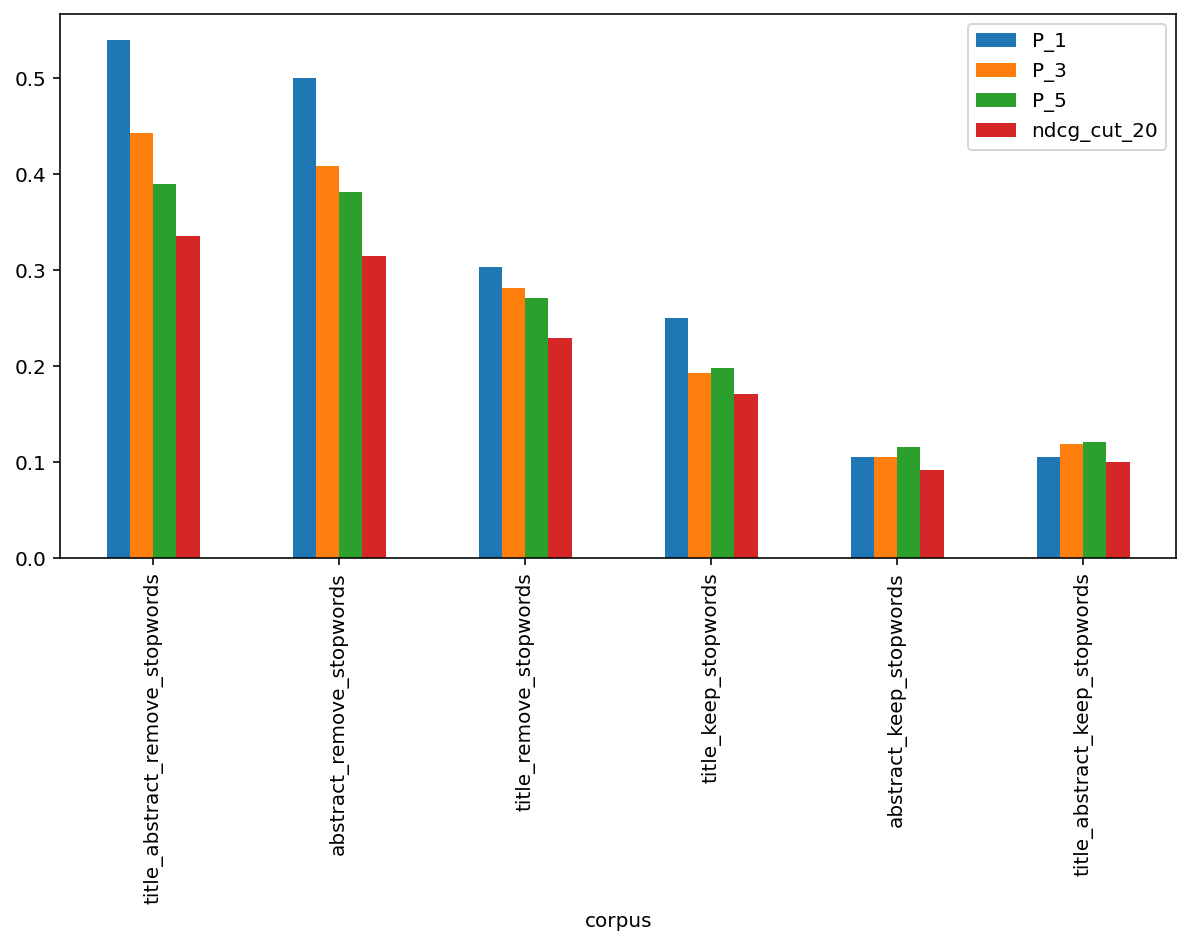

In [239]:
# compute metrics for all combinations of corpus and stopwords
# write results to metrics file
with open('../data/processed/cisi/metrics.txt', 'w') as f:
    for corpus_name, bm25 in bm25_to_test.items():
        results_path = f'../data/processed/cisi/results_{corpus_name}.txt'
        metrics = get_trec_eval_metrics('-M 100 -m all_trec -m P.1,3,5', '../data/processed/cisi/qrels.txt', results_path)
        for metric, value in metrics.items():
            f.write(f'{corpus_name} {metric} {value}\n')

# load into a pandas dataframe and display
metrics = pd.read_csv('../data/processed/cisi/metrics.txt', sep=' ', header=None)
metrics.columns = ['corpus', 'metric', 'value']
# metrics['value'] = metrics['value'].astype(float)
metrics = metrics.pivot(index='corpus', columns='metric', values='value')
metrics.columns.name = None

print('All metrics')
display(metrics)

# plot P1,3,5 and NDCG@20 for all combinations of corpus and stopwords
# remember to convert to float
# sort by best P@1
metrics = metrics[['P_1', 'P_3', 'P_5', 'ndcg_cut_20']].astype(float)
metrics.sort_values('P_1', ascending=False, inplace=True)
metrics[['P_1', 'P_3', 'P_5', 'ndcg_cut_20']].plot.bar(figsize=(10, 5))

print('P@1, P@3, P@5, NDCG@20')
display(metrics[['P_1', 'P_3', 'P_5', 'ndcg_cut_20']])
